# Training and testing 

We train and test different models that perform classification tasks 

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats
#%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [3]:
base_dir = '.' 

dataframes = {}

files = ['Part1_Results.csv', 'Part2_Results.csv', 'Part3_Results.csv']

for file in files:
    file_path = os.path.join(base_dir, file)
    if os.path.exists(file_path):
        # Extract name without extension for dictionary key
        name = file.replace('.csv', '')
        dataframes[name] = pd.read_csv(file_path, sep=';', index_col=0)
        print(f"Loaded {name}: {dataframes[name].shape}")
    else:
        print(f"Warning: {file} not found!")

Loaded Part1_Results: (232, 9)
Loaded Part2_Results: (232, 16)
Loaded Part3_Results: (134, 16)


In [4]:
X_1 = dataframes['Part1_Results'].copy()
X_1.drop(columns=['cell_id', 'cell_type'], inplace=True)
y_1 = dataframes['Part1_Results']['cell_type'].copy()
label_encoder = LabelEncoder()
y_1 = label_encoder.fit_transform(y_1)

if X_1['ap_duration'].isna().any():
    median_val = X_1['ap_duration'].median()
    X_1.loc[:, 'ap_duration'] = X_1['ap_duration'].fillna(median_val)

X_2 = dataframes['Part2_Results'].copy()
X_2.drop(columns=['cell_id', 'cell_type'], inplace=True)
y_2 = dataframes['Part2_Results']['cell_type'].copy()
y_2 = label_encoder.fit_transform(y_2)

X_3 = dataframes['Part3_Results'].copy()
X_3.drop(columns=['cell_id', 'cell_type'], inplace=True)
y_3 = dataframes['Part3_Results']['cell_type'].copy()
y_3 = label_encoder.fit_transform(y_3)  

print("X_2 columns:", X_2.columns.tolist())


X_2 columns: ['numb_events', 'wp_avg', 'wp_amplitude_pre', 'wp_amplitude_post', 'vm_avg', 'vm_amplitude_pre', 'vm_amplitude_post', 'ap_avg', 'ap_psth', 'ap_fr_pre', 'ap_fr_post', 'delta_wp', 'delta_vm', 'delta_ap']


In [5]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_1, y_1, 
    test_size=0.2, 
    stratify=y_1,  #ensures percentages of cell types are preserved
    random_state=42  
)


X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X_3, y_3, 
    test_size=0.2, 
    stratify=y_3,  
    random_state=42  
)

Now, we define the superdataset that comprises the features from the first and second parts only. 

In [6]:
# Build a "superdataset" with shared cell_ids across Part1/2/3, dropping the 8 Part3-only cells.
common_ids = (
    set(dataframes["Part1_Results"]["cell_id"])
    & set(dataframes["Part2_Results"]["cell_id"])
)

def _prep_part(df, prefix):
    tmp = df[df["cell_id"].isin(common_ids)].copy()
    tmp = tmp.set_index("cell_id")
    y = tmp["cell_type"].copy()
    X = tmp.drop(columns=["cell_type"])
    X = X.add_prefix(f"{prefix}__")
    return X, y

X1s, y1s = _prep_part(dataframes["Part1_Results"], "P1")
X2s, y2s = _prep_part(dataframes["Part2_Results"], "P2")

# Safety check: cell_type should match across parts for the shared ids
X_super = X1s.join([X2s], how="inner")
y_super = label_encoder.fit_transform(y1s)

print("Superdataset shape:", X_super.shape)


# Handle NaNs similarly to Part1 ap_duration treatment
if "P1__ap_duration" in X_super.columns and X_super["P1__ap_duration"].isna().any():
    X_super.loc[:, "P1__ap_duration"] = X_super["P1__ap_duration"].fillna(X_super["P1__ap_duration"].median())

X_trainS, X_testS, y_trainS, y_testS = train_test_split(
    X_super, y_super, test_size=0.2, stratify=y_super, random_state=42
)

Superdataset shape: (232, 21)


We define a function that will be used to evaluate the model 

In [7]:
def evaluate_model(model, X_train, X_test, y_train, y_test, dataset_name="", scale=False):    
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # Classification report
    report = classification_report(y_test, y_pred, 
                                   target_names=label_encoder.classes_,
                                   output_dict=True)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    results = {
        'dataset': dataset_name,
        'model': model.__class__.__name__,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'n_features': X_train.shape[1],
        'report': report,
        'confusion_matrix': cm
    }
    
    return results, model

## Model training and testing on Part 1 Data

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [9]:
# Model to train and test
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
    ('SVM Linear', SVC(kernel='linear', class_weight='balanced', random_state=42)),
    ('SVM RBF', SVC(kernel='rbf', class_weight='balanced', random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5, 
                                             class_weight='balanced', random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, max_depth=3, 
                                                     random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=5))
]

In [10]:
# We test each model first on the data from Part 1
all_results = []

for model_name, model in models:

    print(f"-------Testing {model_name}-------")

    
    res1, _ = evaluate_model(model, X_train1, X_test1, y_train1, y_test1, 
                            dataset_name="Part1", scale=True)
    all_results.append(res1)
    print(f"Accuracy: {res1['accuracy']:.3f}, F1-macro: {res1['f1_macro']:.3f}")
    print(f"confusion matrix:")
    print(res1['confusion_matrix'])


# Convert results to DataFrame for comparison
results_df = pd.DataFrame(all_results)

print("SUMMARY OF ALL RESULTS:")

print(results_df[['dataset', 'model', 'accuracy', 'f1_macro', 'n_features']])

-------Testing Logistic Regression-------
Accuracy: 0.830, F1-macro: 0.789
confusion matrix:
[[16  0  0  1]
 [ 0  8  2  0]
 [ 2  0 12  1]
 [ 0  1  1  3]]
-------Testing SVM Linear-------
Accuracy: 0.851, F1-macro: 0.805
confusion matrix:
[[16  0  0  1]
 [ 0  8  2  0]
 [ 1  0 13  1]
 [ 0  1  1  3]]
-------Testing SVM RBF-------
Accuracy: 0.830, F1-macro: 0.765
confusion matrix:
[[17  0  0  0]
 [ 0  8  2  0]
 [ 2  0 12  1]
 [ 0  1  2  2]]
-------Testing Random Forest-------
Accuracy: 0.851, F1-macro: 0.782
confusion matrix:
[[17  0  0  0]
 [ 0  8  2  0]
 [ 1  0 13  1]
 [ 0  1  2  2]]
-------Testing Gradient Boosting-------
Accuracy: 0.851, F1-macro: 0.781
confusion matrix:
[[17  0  0  0]
 [ 0  8  2  0]
 [ 1  0 13  1]
 [ 1  1  1  2]]
-------Testing KNN-------
Accuracy: 0.830, F1-macro: 0.727
confusion matrix:
[[17  0  0  0]
 [ 0  8  2  0]
 [ 2  0 13  0]
 [ 0  1  3  1]]
SUMMARY OF ALL RESULTS:
  dataset                       model  accuracy  f1_macro  n_features
0   Part1          Logistic

Now we do the same for part 2

In [11]:
#Part 2 has vector features, we need to convert them to fixed-size features first.
def parse_vec(s: str) -> np.ndarray:
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return np.array([])
    s = str(s).strip()
    # remove brackets if present
    if s.startswith('[') and s.endswith(']'):
        s = s[1:-1]
    # make commas behave like spaces
    s = s.replace(',', ' ')
    # parse numbers
    return np.fromstring(s, sep=' ')

# Apply parsing to vector features in Part 2
vector_features = ['wp_avg', 'vm_avg', 'ap_avg', 'ap_psth']
print(X_2.columns)
for feature in vector_features:
    X_2[feature] = X_2[feature].apply(parse_vec)

# Now compute summary statistics for each vector feature
X_2["P2__wp_avg_mean"] = X_2["wp_avg"].apply(lambda v: np.mean(v) if v.size else np.nan)
X_2["P2__wp_avg_std"]  = X_2["wp_avg"].apply(lambda v: np.std(v)  if v.size else np.nan)
X_2["P2__wp_avg_min"]  = X_2["wp_avg"].apply(lambda v: np.min(v)  if v.size else np.nan)
X_2["P2__wp_avg_max"]  = X_2["wp_avg"].apply(lambda v: np.max(v)  if v.size else np.nan)
X_2["P2__vm_avg_mean"] = X_2["vm_avg"].apply(lambda v: np.mean(v) if v.size else np.nan)
X_2["P2__vm_avg_std"]  = X_2["vm_avg"].apply(lambda v: np.std(v)  if v.size else np.nan)
X_2["P2__ap_avg_mean"] = X_2["ap_avg"].apply(lambda v: np.mean(v) if v.size else np.nan)
X_2["P2__ap_avg_std"]  = X_2["ap_avg"].apply(lambda v: np.std(v)  if v.size else np.nan)
X_2["P2__ap_avg_min"]  = X_2["ap_avg"].apply(lambda v: np.min(v)  if v.size else np.nan)
X_2["P2__ap_avg_max"]  = X_2["ap_avg"].apply(lambda v: np.max(v)  if v.size else np.nan)    
X_2["P2__ap_psth_mean"] = X_2["ap_psth"].apply(lambda v: np.mean(v) if v.size else np.nan)
X_2["P2__ap_psth_std"]  = X_2["ap_psth"].apply(lambda v: np.std(v)  if v.size else np.nan)
X_2["P2__ap_psth_min"]  = X_2["ap_psth"].apply(lambda v: np.min(v)  if v.size else np.nan)
X_2["P2__ap_psth_max"]  = X_2["ap_psth"].apply(lambda v: np.max(v)  if v.size else np.nan)


# Drop original vector features
for feature in vector_features : 
    X_2 = X_2.drop(columns=[feature])

# Handle any remaining NaNs by removing the corresponding rows. (After manual checking the problematic rows show no data at all)

# Drop rows with NaNs in X_2 and drop the corresponding labels in y_2
mask = X_2.notna().all(axis=1)
X_2 = X_2.loc[mask].copy()
y_2 = y_2[mask.values]

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_2, y_2, 
    test_size=0.2, 
    stratify=y_2,  
    random_state=42  
)

for model_name, model in models:
    print(f"\n{'='*60}")
    print(f"Testing {model_name}")
    print('='*60)

    res1, _ = evaluate_model(model, X_train2, X_test2, y_train2, y_test2, 
                            dataset_name="Part2", scale=True)
    all_results.append(res1)
    print(f"Accuracy: {res1['accuracy']:.3f}, F1-macro: {res1['f1_macro']:.3f}")


# Convert results to DataFrame for comparison
results_df = pd.DataFrame(all_results)

print("SUMMARY OF ALL RESULTS:")

print(results_df[['dataset', 'model', 'accuracy', 'f1_macro', 'n_features']])

Index(['numb_events', 'wp_avg', 'wp_amplitude_pre', 'wp_amplitude_post',
       'vm_avg', 'vm_amplitude_pre', 'vm_amplitude_post', 'ap_avg', 'ap_psth',
       'ap_fr_pre', 'ap_fr_post', 'delta_wp', 'delta_vm', 'delta_ap'],
      dtype='object')

Testing Logistic Regression
Accuracy: 0.587, F1-macro: 0.561

Testing SVM Linear
Accuracy: 0.652, F1-macro: 0.637

Testing SVM RBF


/var/folders/54/ql07hwxs5l7_xz_zv9q3k6k00000gn/T/ipykernel_44158/3636859624.py:12: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  return np.fromstring(s, sep=' ')


Accuracy: 0.739, F1-macro: 0.698

Testing Random Forest
Accuracy: 0.761, F1-macro: 0.774

Testing Gradient Boosting
Accuracy: 0.761, F1-macro: 0.758

Testing KNN
Accuracy: 0.739, F1-macro: 0.692
SUMMARY OF ALL RESULTS:
   dataset                       model  accuracy  f1_macro  n_features
0    Part1          LogisticRegression  0.829787  0.789098           7
1    Part1                         SVC  0.851064  0.805498           7
2    Part1                         SVC  0.829787  0.765186           7
3    Part1      RandomForestClassifier  0.851064  0.781508           7
4    Part1  GradientBoostingClassifier  0.851064  0.781315           7
5    Part1        KNeighborsClassifier  0.829787  0.726940           7
6    Part2          LogisticRegression  0.586957  0.561466          24
7    Part2                         SVC  0.652174  0.636732          24
8    Part2                         SVC  0.739130  0.698321          24
9    Part2      RandomForestClassifier  0.760870  0.774296          24


Now let's compute the metrics for the super dataset

In [12]:
# --- Replicate Part2 preprocessing for vector features inside the superdataset ---
def parse_vec(s: str) -> np.ndarray:
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return np.array([])
    s = str(s).strip()
    if s.startswith('[') and s.endswith(']'):
        s = s[1:-1]
    s = s.replace(',', ' ')
    return np.fromstring(s, sep=' ')

# Identify the P2 vector-like columns in X_super (they were prefixed earlier)
p2_vec_cols = ["P2__wp_avg", "P2__vm_avg", "P2__ap_avg", "P2__ap_psth"]
p2_vec_cols = [c for c in p2_vec_cols if c in X_super.columns]

# Parse vectors from strings -> np.ndarray
for c in p2_vec_cols:
    X_super[c] = X_super[c].apply(parse_vec)

# Create fixed-size summary stats (same behavior as Part2 cell)
if "P2__wp_avg" in X_super.columns:
    X_super["P2__wp_avg_mean"] = X_super["P2__wp_avg"].apply(lambda v: np.mean(v) if v.size else np.nan)
    X_super["P2__wp_avg_std"]  = X_super["P2__wp_avg"].apply(lambda v: np.std(v)  if v.size else np.nan)
    X_super["P2__wp_avg_min"]  = X_super["P2__wp_avg"].apply(lambda v: np.min(v)  if v.size else np.nan)
    X_super["P2__wp_avg_max"]  = X_super["P2__wp_avg"].apply(lambda v: np.max(v)  if v.size else np.nan)

if "P2__vm_avg" in X_super.columns:
    X_super["P2__vm_avg_mean"] = X_super["P2__vm_avg"].apply(lambda v: np.mean(v) if v.size else np.nan)
    X_super["P2__vm_avg_std"]  = X_super["P2__vm_avg"].apply(lambda v: np.std(v)  if v.size else np.nan)

if "P2__ap_avg" in X_super.columns:
    X_super["P2__ap_avg_mean"] = X_super["P2__ap_avg"].apply(lambda v: np.mean(v) if v.size else np.nan)
    X_super["P2__ap_avg_std"]  = X_super["P2__ap_avg"].apply(lambda v: np.std(v)  if v.size else np.nan)
    X_super["P2__ap_avg_min"]  = X_super["P2__ap_avg"].apply(lambda v: np.min(v)  if v.size else np.nan)
    X_super["P2__ap_avg_max"]  = X_super["P2__ap_avg"].apply(lambda v: np.max(v)  if v.size else np.nan)

if "P2__ap_psth" in X_super.columns:
    X_super["P2__ap_psth_mean"] = X_super["P2__ap_psth"].apply(lambda v: np.mean(v) if v.size else np.nan)
    X_super["P2__ap_psth_std"]  = X_super["P2__ap_psth"].apply(lambda v: np.std(v)  if v.size else np.nan)
    X_super["P2__ap_psth_min"]  = X_super["P2__ap_psth"].apply(lambda v: np.min(v)  if v.size else np.nan)
    X_super["P2__ap_psth_max"]  = X_super["P2__ap_psth"].apply(lambda v: np.max(v)  if v.size else np.nan)

# Drop original vector columns
if p2_vec_cols:
    X_super = X_super.drop(columns=p2_vec_cols)

# Handle NaNs like in Part2: drop rows with any NaN and align y
mask = X_super.notna().all(axis=1)
X_super = X_super.loc[mask].copy()
y_super = y_super[mask.values]

# Recreate the split for the cleaned superdataset
X_trainS, X_testS, y_trainS, y_testS = train_test_split(
    X_super, y_super, test_size=0.2, stratify=y_super, random_state=42
)

# Keep Part1-style NaN handling for ap_duration if present (no-op if already clean)
if "P1__ap_duration" in X_super.columns and X_super["P1__ap_duration"].isna().any():
    X_super.loc[:, "P1__ap_duration"] = X_super["P1__ap_duration"].fillna(X_super["P1__ap_duration"].median())
for model_name, model in models:
    print(f"\n{'='*60}")
    print(f"Testing {model_name}")
    print('='*60)

    res1, _ = evaluate_model(model, X_trainS, X_testS, y_trainS, y_testS, 
                            dataset_name="Part1+Part2", scale=True)
    all_results.append(res1)
    print(f"Accuracy: {res1['accuracy']:.3f}, F1-macro: {res1['f1_macro']:.3f}")


# Convert results to DataFrame for comparison
results_df = pd.DataFrame(all_results)

print("SUMMARY OF ALL RESULTS:")

print(results_df[['dataset', 'model', 'accuracy', 'f1_macro', 'n_features']])

/var/folders/54/ql07hwxs5l7_xz_zv9q3k6k00000gn/T/ipykernel_44158/2476337168.py:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  return np.fromstring(s, sep=' ')



Testing Logistic Regression
Accuracy: 0.870, F1-macro: 0.858

Testing SVM Linear
Accuracy: 0.783, F1-macro: 0.762

Testing SVM RBF
Accuracy: 0.913, F1-macro: 0.886

Testing Random Forest
Accuracy: 0.783, F1-macro: 0.714

Testing Gradient Boosting
Accuracy: 0.913, F1-macro: 0.889

Testing KNN
Accuracy: 0.891, F1-macro: 0.830
SUMMARY OF ALL RESULTS:
        dataset                       model  accuracy  f1_macro  n_features
0         Part1          LogisticRegression  0.829787  0.789098           7
1         Part1                         SVC  0.851064  0.805498           7
2         Part1                         SVC  0.829787  0.765186           7
3         Part1      RandomForestClassifier  0.851064  0.781508           7
4         Part1  GradientBoostingClassifier  0.851064  0.781315           7
5         Part1        KNeighborsClassifier  0.829787  0.726940           7
6         Part2          LogisticRegression  0.586957  0.561466          24
7         Part2                         S

Comparing the best possible accuracy across the different datasets the models use, we cn see that the super dataset always has at least one model with a better accuracy. 

Now, let's try with the 3rd part as well

In [13]:
# --- Build a new superdataset that includes Part1 + Part2 + Part3 (shared cell_ids only) ---

common_ids_123 = (
    set(dataframes["Part1_Results"]["cell_id"])
    & set(dataframes["Part2_Results"]["cell_id"])
    & set(dataframes["Part3_Results"]["cell_id"])
)

def _prep_part(df, prefix, ids):
    tmp = df[df["cell_id"].isin(ids)].copy().set_index("cell_id")
    y = tmp["cell_type"].copy()
    X = tmp.drop(columns=["cell_type"])
    X = X.add_prefix(f"{prefix}__")
    return X, y

X1s_123, y1s_123 = _prep_part(dataframes["Part1_Results"], "P1", common_ids_123)
X2s_123, y2s_123 = _prep_part(dataframes["Part2_Results"], "P2", common_ids_123)
X3s_123, y3s_123 = _prep_part(dataframes["Part3_Results"], "P3", common_ids_123)

X_super123 = X1s_123.join([X2s_123, X3s_123], how="inner")
y_super123 = label_encoder.fit_transform(y1s_123)

print("Superdataset (Part1+Part2+Part3) shape before preprocessing:", X_super123.shape)

# --- Part2 vector-feature preprocessing inside the new superdataset (same logic as before) ---
vec_cols = ["P2__wp_avg", "P2__vm_avg", "P2__ap_avg", "P2__ap_psth", "P3__wp_avg", "P3__vm_avg", "P3__ap_avg", "P3__ap_psth"]
vec_cols = [c for c in vec_cols if c in X_super123.columns]


for c in vec_cols:
    X_super123[c] = X_super123[c].apply(parse_vec)

if "P2__wp_avg" in X_super123.columns:
    X_super123["P2__wp_avg_mean"] = X_super123["P2__wp_avg"].apply(lambda v: np.mean(v) if v.size else np.nan)
    X_super123["P2__wp_avg_std"]  = X_super123["P2__wp_avg"].apply(lambda v: np.std(v)  if v.size else np.nan)
    X_super123["P2__wp_avg_min"]  = X_super123["P2__wp_avg"].apply(lambda v: np.min(v)  if v.size else np.nan)
    X_super123["P2__wp_avg_max"]  = X_super123["P2__wp_avg"].apply(lambda v: np.max(v)  if v.size else np.nan)

if "P2__vm_avg" in X_super123.columns:
    X_super123["P2__vm_avg_mean"] = X_super123["P2__vm_avg"].apply(lambda v: np.mean(v) if v.size else np.nan)
    X_super123["P2__vm_avg_std"]  = X_super123["P2__vm_avg"].apply(lambda v: np.std(v)  if v.size else np.nan)

if "P2__ap_avg" in X_super123.columns:
    X_super123["P2__ap_avg_mean"] = X_super123["P2__ap_avg"].apply(lambda v: np.mean(v) if v.size else np.nan)
    X_super123["P2__ap_avg_std"]  = X_super123["P2__ap_avg"].apply(lambda v: np.std(v)  if v.size else np.nan)
    X_super123["P2__ap_avg_min"]  = X_super123["P2__ap_avg"].apply(lambda v: np.min(v)  if v.size else np.nan)
    X_super123["P2__ap_avg_max"]  = X_super123["P2__ap_avg"].apply(lambda v: np.max(v)  if v.size else np.nan)

if "P2__ap_psth" in X_super123.columns:
    X_super123["P2__ap_psth_mean"] = X_super123["P2__ap_psth"].apply(lambda v: np.mean(v) if v.size else np.nan)
    X_super123["P2__ap_psth_std"]  = X_super123["P2__ap_psth"].apply(lambda v: np.std(v)  if v.size else np.nan)
    X_super123["P2__ap_psth_min"]  = X_super123["P2__ap_psth"].apply(lambda v: np.min(v)  if v.size else np.nan)
    X_super123["P2__ap_psth_max"]  = X_super123["P2__ap_psth"].apply(lambda v: np.max(v)  if v.size else np.nan)

if "P3__wp_avg" in X_super123.columns:
    X_super123["P3__wp_avg_mean"] = X_super123["P3__wp_avg"].apply(lambda v: np.mean(v) if v.size else np.nan)
    X_super123["P3__wp_avg_std"]  = X_super123["P3__wp_avg"].apply(lambda v: np.std(v)  if v.size else np.nan)
    X_super123["P3__wp_avg_min"]  = X_super123["P3__wp_avg"].apply(lambda v: np.min(v)  if v.size else np.nan)
    X_super123["P3__wp_avg_max"]  = X_super123["P3__wp_avg"].apply(lambda v: np.max(v)  if v.size else np.nan)

if "P3__vm_avg" in X_super123.columns:
    X_super123["P3__vm_avg_mean"] = X_super123["P3__vm_avg"].apply(lambda v: np.mean(v) if v.size else np.nan)
    X_super123["P3__vm_avg_std"]  = X_super123["P3__vm_avg"].apply(lambda v: np.std(v)  if v.size else np.nan)
    X_super123["P3__vm_avg_min"]  = X_super123["P3__vm_avg"].apply(lambda v: np.min(v)  if v.size else np.nan)
    X_super123["P3__vm_avg_max"]  = X_super123["P3__vm_avg"].apply(lambda v: np.max(v)  if v.size else np.nan)

if "P3__ap_avg" in X_super123.columns:
    X_super123["P3__ap_avg_mean"] = X_super123["P3__ap_avg"].apply(lambda v: np.mean(v) if v.size else np.nan)
    X_super123["P3__ap_avg_std"]  = X_super123["P3__ap_avg"].apply(lambda v: np.std(v)  if v.size else np.nan)
    X_super123["P3__ap_avg_min"]  = X_super123["P3__ap_avg"].apply(lambda v: np.min(v)  if v.size else np.nan)
    X_super123["P3__ap_avg_max"]  = X_super123["P3__ap_avg"].apply(lambda v: np.max(v)  if v.size else np.nan)

if "P3__ap_psth" in X_super123.columns:
    X_super123["P3__ap_psth_mean"] = X_super123["P3__ap_psth"].apply(lambda v: np.mean(v) if v.size else np.nan)
    X_super123["P3__ap_psth_std"]  = X_super123["P3__ap_psth"].apply(lambda v: np.std(v)  if v.size else np.nan)
    X_super123["P3__ap_psth_min"]  = X_super123["P3__ap_psth"].apply(lambda v: np.min(v)  if v.size else np.nan)
    X_super123["P3__ap_psth_max"]  = X_super123["P3__ap_psth"].apply(lambda v: np.max(v)  if v.size else np.nan)
# Drop original vector columns


if vec_cols:
    X_super123 = X_super123.drop(columns=vec_cols)


# --- Part1 NaN handling for ap_duration (median fill), consistent with earlier logic ---
if "P1__ap_duration" in X_super123.columns and X_super123["P1__ap_duration"].isna().any():
    X_super123.loc[:, "P1__ap_duration"] = X_super123["P1__ap_duration"].fillna(
        X_super123["P1__ap_duration"].median()
    )

# --- Drop rows with any NaN and align labels (same as Part2/super logic) ---
mask = X_super123.notna().all(axis=1)
X_super123 = X_super123.loc[mask].copy()
y_super123 = y_super123[mask.values]

print("Superdataset (Part1+Part2+Part3) shape after preprocessing:", X_super123.shape)

# --- Split and evaluate all models on Part1+Part2+Part3 ---
X_trainS123, X_testS123, y_trainS123, y_testS123 = train_test_split(
    X_super123, y_super123, test_size=0.2, stratify=y_super123, random_state=42
)

for model_name, model in models:
    print(f"\n{'='*60}")
    print(f"Testing {model_name}")
    print('='*60)

    res, _ = evaluate_model(
        model, X_trainS123, X_testS123, y_trainS123, y_testS123,
        dataset_name="Part1+Part2+Part3", scale=True
    )
    all_results.append(res)
    print(f"Accuracy: {res['accuracy']:.3f}, F1-macro: {res['f1_macro']:.3f}")

results_df = pd.DataFrame(all_results)
print("SUMMARY OF ALL RESULTS:")
print(results_df[['dataset', 'model', 'accuracy', 'f1_macro', 'n_features']])

Superdataset (Part1+Part2+Part3) shape before preprocessing: (126, 35)
Superdataset (Part1+Part2+Part3) shape after preprocessing: (123, 57)

Testing Logistic Regression
Accuracy: 0.960, F1-macro: 0.900

Testing SVM Linear
Accuracy: 0.960, F1-macro: 0.900

Testing SVM RBF


/var/folders/54/ql07hwxs5l7_xz_zv9q3k6k00000gn/T/ipykernel_44158/2476337168.py:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  return np.fromstring(s, sep=' ')


Accuracy: 0.960, F1-macro: 0.900

Testing Random Forest


/Users/gouledhema/opt/anaconda3/envs/bio482_py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gouledhema/opt/anaconda3/envs/bio482_py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gouledhema/opt/anaconda3/envs/bio482_py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

Accuracy: 0.840, F1-macro: 0.645

Testing Gradient Boosting
Accuracy: 0.920, F1-macro: 0.943

Testing KNN
Accuracy: 0.920, F1-macro: 0.706
SUMMARY OF ALL RESULTS:
              dataset                       model  accuracy  f1_macro  \
0               Part1          LogisticRegression  0.829787  0.789098   
1               Part1                         SVC  0.851064  0.805498   
2               Part1                         SVC  0.829787  0.765186   
3               Part1      RandomForestClassifier  0.851064  0.781508   
4               Part1  GradientBoostingClassifier  0.851064  0.781315   
5               Part1        KNeighborsClassifier  0.829787  0.726940   
6               Part2          LogisticRegression  0.586957  0.561466   
7               Part2                         SVC  0.652174  0.636732   
8               Part2                         SVC  0.739130  0.698321   
9               Part2      RandomForestClassifier  0.760870  0.774296   
10              Part2  GradientBoo

/Users/gouledhema/opt/anaconda3/envs/bio482_py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gouledhema/opt/anaconda3/envs/bio482_py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gouledhema/opt/anaconda3/envs/bio482_py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

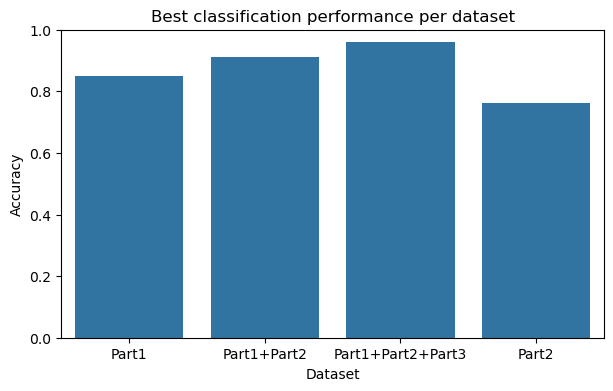

In [45]:
# best model per dataset (highest F1)
best_per_dataset = (
    results_df
    .sort_values("accuracy", ascending=False)
    .groupby("dataset")
    .first()
    .reset_index()
)

plt.figure(figsize=(7,4))
sns.barplot(data=best_per_dataset, x="dataset", y="accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Dataset")
plt.title("Best classification performance per dataset")
plt.ylim(0,1)
plt.show()

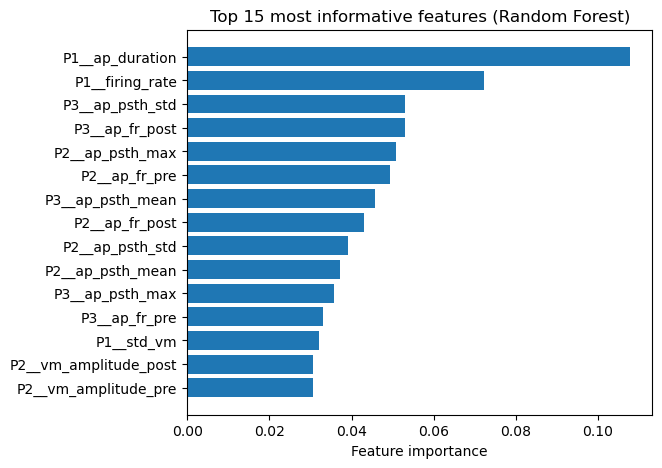

In [ ]:
#plot des most informative features
from sklearn.ensemble import RandomForestClassifier

# Re-train a Random Forest for interpretation
rf = RandomForestClassifier(random_state=42)
rf.fit(X_trainS123, y_trainS123)

importances = rf.feature_importances_
feat_names = X_trainS123.columns

idx = importances.argsort()[-15:]

plt.figure(figsize=(6,5))
plt.barh(feat_names[idx], importances[idx])
plt.xlabel("Feature importance")
plt.title("Top 15 most informative features (Random Forest)")
plt.show()


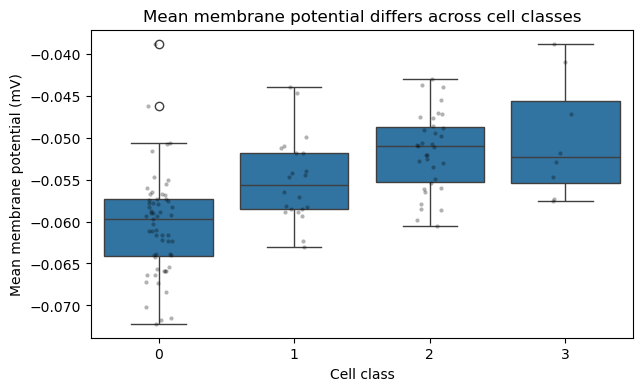

In [39]:
#Plot potentiel de membrane moyen par classe
df_vm = pd.DataFrame({
    "cell_class": y_super123,
    "vm_mean": X_super123["P2__vm_avg_mean"]
})

plt.figure(figsize=(7,4))
sns.boxplot(data=df_vm, x="cell_class", y="vm_mean")
sns.stripplot(data=df_vm, x="cell_class", y="vm_mean",
              color="black", alpha=0.3, size=3)

plt.xlabel("Cell class")
plt.ylabel("Mean membrane potential (mV)")
plt.title("Mean membrane potential differs across cell classes")
plt.show()

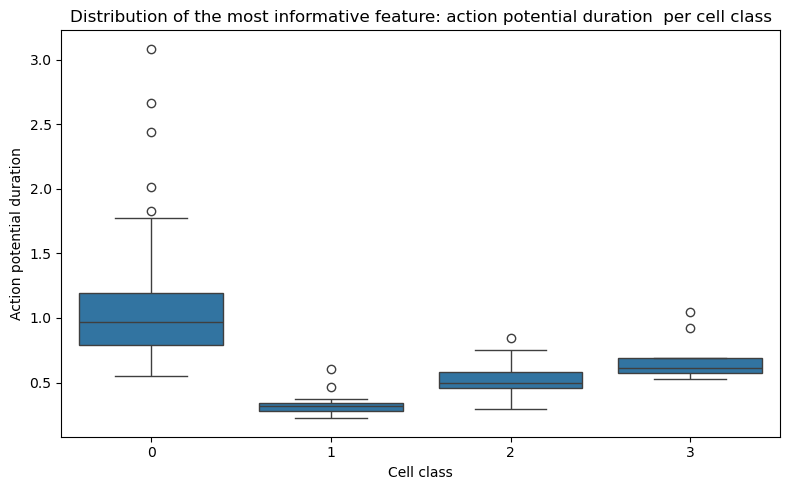

In [40]:
# plot du most informative feature 
plot_df = pd.DataFrame({
    "ap_duration": X_super123["P1__ap_duration"],
    "cell_class": y_super123
})

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=plot_df,
    x="cell_class",
    y="ap_duration"
)

plt.xlabel("Cell class")
plt.ylabel("Action potential duration")
plt.title("Distribution of the most informative feature: action potential duration  per cell class")

plt.tight_layout()
plt.show()